# Train Neural Network
## Parse and prepare the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
import os
import fileinput
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Ftrl
from tensorflow.keras.layers import Dropout

import time

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run

TensorFlow version = 2.6.2



In [2]:
# SEED = 1337
# np.random.seed(SEED)
# tf.random.set_seed(SEED)

CLASSES = [];

# get all csv files and uses their names for the classes
for file in os.listdir("../data/17-04"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])
# sort the classes
CLASSES.sort()

print(CLASSES)

['box-own', 'laptop-own', 'monitor-combined', 'pc-combined', 'pc_brother', 'pc_jarno', 'pc_lukas', 'phone-own', 'printer-combined', 'switch-afstand', 'tv_combined', 'tv_jarno', 'tv_lukas']


In [3]:
NUM_CLASSES = len(CLASSES) # get the number of classes

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

# the input and output tensor
inputs = []
outputs = []

# determines how many samples to use for each input
SAMPLES_PER_CLASS = 25

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("../data/17-04/" + objectClass + ".csv")
  # drop any unused parameters
  df = df.drop(columns=['time'])
  df = df.drop(columns=['Voltage'])
  df = df.drop(columns=['Factor'])
  columns = list(df)
  # get rid of empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)

  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_CLASS)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  # fill the input and output tensors
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_CLASS):
        # the index of the next sample to add
        index = i * SAMPLES_PER_CLASS + j
        tensor += [
            df['ApparentPower'][index],
            df['Current'][index],
            # df['Factor'][index],
            df['Power'][index],
            df['ReactivePower'][index],        
        ]
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)

# Scale the columns of X to be between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler()
inputs_scaled = scaler.fit_transform(inputs)
joblib.dump(scaler, 'scaler.gz')

# print shape of an input
print(inputs[0].shape)
outputs = np.array(outputs) # convert the outputs to a numpy array
print(CLASSES)


box-own class will be output 0 of the classifier
3155 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

laptop-own class will be output 1 of the classifier
1244 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

monitor-combined class will be output 2 of the classifier
8572 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

pc-combined class will be output 3 of the classifier
20694 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

pc_brother class will be output 4 of the classifier
4688 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

pc_jarno class will be output 5 of the classifier
4670 samples captured for training with inputs ['ApparentPower', 'Current', 'Power', 'ReactivePower'] 

pc_lukas class will be output 6 of the classifier
4657 sample

In [4]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs_scaled = inputs_scaled[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs_scaled, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")
print(inputs_test)
print(num_inputs)

Data set randomization and splitting complete.
[[0.02539062 0.02699694 0.00223214 ... 0.02686066 0.00223214 0.03553299]
 [0.29296875 0.30698581 0.27008929 ... 0.28259653 0.27008929 0.17005076]
 [0.01757812 0.02365711 0.00892857 ... 0.02350308 0.00892857 0.02284264]
 ...
 [0.06445312 0.08433064 0.07589286 ... 0.0766648  0.06026786 0.04314721]
 [0.00195312 0.00250487 0.         ... 0.00391718 0.         0.00761421]
 [0.15625    0.16170331 0.10044643 ... 0.16172356 0.10044643 0.17005076]]
72635


# Test code voor de tijd in de csv om te zetten

#Build & Train the Model
Build and train a TensorFlow model using the high-level Keras API.

In [5]:
# https://www.kaggle.com/getting-started/174307
from sklearn.metrics import accuracy_score

# callback to only print metrics every X epochs
class Callback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X = X_val
        self.y = y_val.argmax(axis=1)
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0:
            return
        if epoch%10==0: #Hier aanpassan na hoeveel epochs je wilt zien
            pred = (model.predict(self.X))
            print('epoch: ',epoch, ' | loss: ', str(logs['loss']), '| val_loss: ', str(logs['val_loss']), '| accuracy: ', accuracy_score(self.y,pred.argmax(axis=1)))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10) # early stopping -> will sotp training if no improvement for 10 epochs
# build the model and train it
model = tf.keras.Sequential()
# model.add(Dropout(0.5))
model.add(tf.keras.layers.Dense(100, activation='relu')) # relu is used for performance (50
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(200, activation='relu')) #30
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(100, activation='relu')) #20
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=32, validation_data=(inputs_validate, outputs_validate), callbacks=[Callback(inputs_validate, outputs_validate)], verbose=0)
model.summary() #500 32

2023-04-18 07:22:24.528015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 07:22:24.528154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 07:22:24.530841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 07:22:24.530942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 07:22:24.531028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

epoch:  10  | loss:  0.024189798161387444 | val_loss:  0.022736962884664536 | accuracy:  0.7383492806498244
epoch:  20  | loss:  0.022520948201417923 | val_loss:  0.021717241033911705 | accuracy:  0.7426860329042473
epoch:  30  | loss:  0.021799663081765175 | val_loss:  0.022163795307278633 | accuracy:  0.7408274247952089
epoch:  40  | loss:  0.021518493071198463 | val_loss:  0.02069818042218685 | accuracy:  0.7482618572313623
epoch:  50  | loss:  0.021031200885772705 | val_loss:  0.02089093253016472 | accuracy:  0.7532181455221312
epoch:  60  | loss:  0.020964689552783966 | val_loss:  0.021429860964417458 | accuracy:  0.743787430302196
epoch:  70  | loss:  0.020911576226353645 | val_loss:  0.021269991993904114 | accuracy:  0.7445446410132857
epoch:  80  | loss:  0.020545074716210365 | val_loss:  0.021101446822285652 | accuracy:  0.749019067942452
epoch:  90  | loss:  0.02063615620136261 | val_loss:  0.020847242325544357 | accuracy:  0.7538376815584773
epoch:  100  | loss:  0.020410863

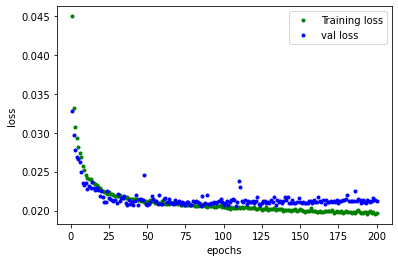

In [6]:
# get the training loss and validation loss history values
loss = history.history['loss']
val_loss = history.history['val_loss']

# the number of epochs
epochs = range(1, len(loss)+1)

# plot the training and validation loss
plt.plot(epochs, loss, 'g.', label="Training loss")
plt.plot(epochs, val_loss, 'b.', label="val loss")

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Run with Test Data

(14527, 100)
predictions =
 [[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.001 0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]]
actual =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[9.87804878e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 9.41406250e-01 1.70648464e-03 1.31851573e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.70776256e-04 0.00000000e+00
  1.77304965e-03]
 [3.04878049e-03 0.00000000e+00 9.84072810e-01 4.33226596e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.487547

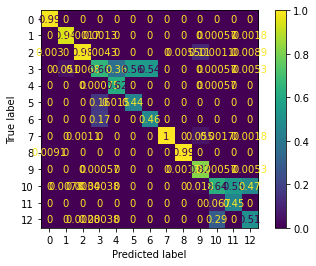

In [7]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
print(inputs_test.shape)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

y_prediction = np.argmax(predictions, axis = 1)
y_test=np.argmax(outputs_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
disp =  ConfusionMatrixDisplay(confusion_matrix=result)
print(result)
disp.plot()

In [8]:
# save the model
model.save('model_saved1.0_17-04/')

2023-04-18 07:25:52.713931: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_saved1.0_17-04/assets


In [9]:
# save the notebook
!tar chvfz notebook.tar.gz *

classification_device.ipynb
model_saved/
model_saved/keras_metadata.pb
model_saved/saved_model.pb
model_saved/assets/
model_saved/variables/
model_saved/variables/variables.index
model_saved/variables/variables.data-00000-of-00001
model_saved1.0_17-04/
model_saved1.0_17-04/keras_metadata.pb
model_saved1.0_17-04/saved_model.pb
model_saved1.0_17-04/assets/
model_saved1.0_17-04/variables/
model_saved1.0_17-04/variables/variables.index
model_saved1.0_17-04/variables/variables.data-00000-of-00001
model_saved1.0_28-03/
model_saved1.0_28-03/keras_metadata.pb
model_saved1.0_28-03/saved_model.pb
model_saved1.0_28-03/assets/
model_saved1.0_28-03/variables/
model_saved1.0_28-03/variables/variables.index
model_saved1.0_28-03/variables/variables.data-00000-of-00001
model_saved1.0_only_usage/
model_saved1.0_only_usage/keras_metadata.pb
model_saved1.0_only_usage/saved_model.pb
model_saved1.0_only_usage/assets/
model_saved1.0_only_usage/variables/
model_saved1.0_only_usage/variables/variables.index
mo